# **Insurance Pricing Forecast Using XGBoost Regressor**

## **Project Overview**

Insurance companies provide coverage for expenses incurred by policyholders due to damages to health or property. The policies they commonly offer encompass medical bills, home, motor vehicle, and fire insurance, as well as financial losses like income loss, all in exchange for a fee or premium paid by the client. Conventional methods of calculating premiums necessitate significant manual labor, and their complexity is continuously growing to account for the intricate data interactions.

Insurance companies typically aim to collect a premium higher than the sum they pay to the insured individual in the event of a valid claim, ensuring profitability. Profitability is the linchpin for the insurance firm's sustainability, thus prompting the need for a dependable mechanism to forecast healthcare expenditures.

Consequently, our objective revolves around constructing a machine learning model to aid in setting rates by predicting the charges or payouts facilitated by the health insurance firm, thereby maintaining profitability.

In this project, our primary focus lies in constructing an XGBoost Regressor to ascertain healthcare expenses based on features such as age, BMI, smoking habits, and more. We'll delve into understanding categorical correlations, building a linear regression model as a baseline, and subsequently comparing it to the outcomes of the XGBoost regressor. Ultimately, we'll acquire the skill of effectively conveying technical outcomes to non-technical stakeholders

## **Important Libraries**
 
* **Pandas**: pandas is a fast, powerful, flexible, and easy-to-use open-source data analysis and manipulation tool built on top of the Python programming language. Refer to [documentation](https://pandas.pydata.org/) for more information.
 
* **NumPy**: The fundamental package for scientific computing with Python. Fast and versatile, the NumPy vectorization, indexing, and broadcasting concepts are the de-facto standards of array computing today. NumPy offers comprehensive mathematical functions, random number generators, linear algebra routines, Fourier transforms, and more. Refer to [documentation](https://numpy.org/) for more information. pandas and NumPy are together used for most of the data analysis and manipulation in Python.
 
* **Matplotlib**: Matplotlib is a comprehensive library for creating static, animated, and interactive visualizations in Python. Refer to [documentation](https://matplotlib.org/) for more information.
 
 
* **scikit-learn**: Simple and efficient tools for predictive data analysis
accessible to everybody and reusable in various contexts.
It is built on NumPy, SciPy, and matplotlib to support machine learning in Python. Refer to [documentation](https://scikit-learn.org/stable/) for more information.

* **statsmodels**: statsmodels is a Python module that provides classes and functions for the estimation of many different statistical models, as well as for conducting statistical tests and statistical data exploration. Refer to [documentation](https://www.statsmodels.org/stable/index.html) for more information.

* **plotly**: Plotly's Python graphing library makes interactive, publication-quality graphs. Examples of how to make line plots, scatter plots, area charts, bar charts, error bars, box plots, histograms, heatmaps, subplots, multiple-axes, polar charts, and bubble charts. Refer to [documentation](https://plotly.com/python/) for more information.

* **scikit-optimize**: Scikit optimize enables sequential model based optimization in Python. Refer to [documentation](https://scikit-optimize.github.io/stable/) for more information.

* **category_encoders**: A set of scikit-learn-style transformers for encoding categorical variables into numeric with different techniques. Refer to [documentation](https://contrib.scikit-learn.org/category_encoders/) for more information.

* **xgboost**: XGBoost is an optimized distributed gradient boosting library designed to be highly efficient, flexible and portable. It implements machine learning algorithms under the Gradient Boosting framework. XGBoost provides a parallel tree boosting (also known as GBDT, GBM) that solve many data science problems in a fast and accurate way.

### **Import Libraries**

In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import sys
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import math
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.feature_selection import RFE
import plotly.io as pio
from plotly.offline import plot, iplot, init_notebook_mode
import plotly.graph_objs as go
init_notebook_mode(connected=True)

And the functions in the `ml_pipeline` folder:

In [44]:
sys.path.append("ml_pipeline/")
from eda import plot_histograms, plot_univariate_numeric, plot_univariate_categorical, plot_heatmap, plot_paired_boxplots, plot_paired_scatterplots, plot_residuals, plot_pearson_wrt_target
from stats import chi2, anova
from model_performance import calc_model_performance, compare_model_performance, calc_preds_in_residual_range, calc_preds_in_residual_perc_range

## **Exploratory Data Analysis (EDA)**

Exploratory Data Analysis, commonly referred to as EDA, is a methodology employed to dissect data through visual representation. This approach involves utilizing both statistical measures and visual techniques to pinpoint specific trends within the dataset.

EDA serves the purpose of comprehending data patterns, identifying anomalies, validating assumptions, and more. Its primary objective is to provide insights into the data landscape before forming any hypotheses.

In the realm of constructing a machine learning model, EDA stands as a crucial initial step. It grants us the capacity to grasp the distribution and interrelations of variables, as well as to gauge the potential predictive strength of various features.

Let us commence by importing the dataset, which is stored within the insurance.csv file located in the input folder:

In [45]:
data = pd.read_csv("data/insurance.csv")
data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [46]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


NOTE: Absence of null values across all columns negates the necessity for value imputation during the Data preprocessing phase. Nevertheless, this is typically a facet that warrants attention while constructing a machine learning model.

The target (i.e., the variable we aim to forecast) is the charges column; hence, let's bifurcate the dataset into features (X) and the target (y):

In [47]:
target = 'charges'
X = data.drop(target, axis=1)
y = data[target]

In [48]:
X.shape, y.shape

((1338, 6), (1338,))

In [49]:
plot_histograms(X)

Key observations regarding the distribution of individual features:

* `age` - Displays an approximately uniform distribution.
* `sex` - Demonstrates nearly equal volume across each category.
* `bmi` - Exhibits an approximately normal distribution.
* `children` - Shows right skewness, indicating a greater volume in the lower range.
* `smoker` - Evidences significantly higher volume in the no category compared to the yes category.
* `region` - Presents an approximately balanced volume in each category.

In [50]:
plot_histograms(pd.DataFrame(y), height=300)

The distribution is right skewed (i.e. higher volume in the lower range).

#### Numeric features

In [51]:
plot_univariate_numeric(X.select_dtypes(include="number"), y)

Points to note regarding each feature:

* `age` - As `age` increases, `charges` also tends to increase (although there is a large variance in `charges` for a given `age`).
* `bmi` - There is no clear relationship, although there seems to be a group of individuals with `bmi` > 30 that have `charges` > 30k. This group may become more apparent when we carry out our bivariate analysis later.
* `children` - No clear relationship (although `charges` seems to decrease as `children` increases). **Since there are only 6 unique values for this feature, let's try treating it as a categorical feature for the purposes of univariate analysis.**

#### Categorical features

In [52]:
plot_univariate_categorical(X[['sex', 'smoker', 'region', 'children']], y)

Points to note regarding each feature:

* `sex` - No significant differences in `charges` between the categories.
* `smoker` - `charges` for `smoker` == 'yes' are generally much higher than when `smoker` == 'no'.
* `region` - No significant differences in `charges` between the categories.
* `children` - No significant differences in `charges` between the categories (`children` >= 4 are skewed towards lower `charges`, but this is likely due to the low volumes in those categories - see the **Distributions** section).

In [53]:
plot_heatmap(X[['age', 'bmi', 'children']], y, bins=10)

No additional insight can be gained from these plots that we haven't already obtained from the univariate analysis.

In [54]:
plot_paired_boxplots(X[['sex', 'smoker', 'region']], y)

Points to note regarding these feature pairs:

* `sex`-`smoker` - The median `charges` is higher for males who smoke compared to females who smoke (36k vs 29k)
* `smoker`-`region` - The median `charges` is higher for smokers in the southwest and southeast vs the northeast and northwest (35k and 37k vs 28k and 27k)

In [55]:
plot_paired_scatterplots(X, y)

There are two pieces of insight from these graphs:

* `age`-`smoker` - There is a group in the bottom left hand quadrant of the chart (where `age` < 50 and `smoker` = 'no') where all beneficiaries have health care costs below 10k (which is relatively small compared to the rest of the population).
* `bmi`-`smoker` - There is a group in the top right hand quadrant of the chart (where `bmi` > 30 and `smoker` = 'yes') where all beneficiaries have health care costs above 30k (which is relatively large compared to the rest of the population).

#### **Numeric features**

In [56]:
px.scatter_matrix(
    X.select_dtypes(include=np.number)
)

There doesn't look like there's much correlation between any of the numeric features. To be sure, let's calculate and plot the **Pearson's correlation matrix**:

In [57]:
px.imshow(X.select_dtypes(include=np.number).corr())

This suggests there is very little correlation between the numeric features - the highest being a Pearson's correlation of 0.11.

#### **Categorical features**

In [58]:
X_chi2 = chi2(X.select_dtypes(object))

In [59]:
X_chi2

,column1,column2,chi_squared,p_value,dof
0,sex,smoker,7.392911,0.006548,1
1,sex,region,0.435137,0.932892,3
2,smoker,region,7.343478,0.061720,3


A threshold of < 0.05 is widely accepted for rejecting the null-hypothesis (that the features are independent) since this means that there is only a 5% probability of observing the distribution by chance.

The only feature pair with a p-value less than this threshold is `sex` and `smoker`, which means it's likely that these features are correlated:

#### **Numeric-categorical feature pairs**

In [60]:
X_anova = anova(X)

In [61]:
X_anova

,num_column,cat_column,f_stat,p_value
0,age,sex,0.581369,4.459107e-01
1,age,smoker,0.836777,3.604853e-01
2,age,region,0.079782,9.709891e-01
3,bmi,sex,2.878970,8.997637e-02
4,bmi,smoker,0.018792,8.909850e-01
5,bmi,region,39.495057,1.881839e-24
6,children,sex,0.393659,5.304898e-01
7,children,smoker,0.078664,7.791596e-01
8,children,region,0.717493,5.415543e-01


The only feature pair with a p-value less than this threshold is `bmi` and `region`, which means it's likely that these features are correlated:

### **Correlation (with respect to the target)**

#### **Numeric features (with respect to the target)**

In [62]:
plot_pearson_wrt_target(X, y)

The `children` feature has a very low correlation with respect to the target.

#### **Categorical features (with respect to the target)**

In [63]:
data_anova = anova(data)
anova_wrt_target = data_anova[data_anova['num_column']=='charges']

In [64]:
anova_wrt_target

,num_column,cat_column,f_stat,p_value
9,charges,sex,4.399702,3.613272e-02
10,charges,smoker,2177.614868,8.271436e-283
11,charges,region,2.969627,3.089336e-02


All p-values are < 0.05, which means that the differences observed in the `charges` column when comparing the categories within a categorical variable are statistically significant. **Note however that this doesn't measure the magnitude of the differences observed.**

In [65]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

#### **Remove unnecessary columns**

In [66]:
cols_to_drop = ['children', 'region', 'sex']
X_train.drop(cols_to_drop, axis=1, inplace=True)
X_test.drop(cols_to_drop, axis=1, inplace=True)

After our EDA, we concluded that the `children` feature is not strongly correlated to `charges`. This violates Assumption 2 of a linear regression model, so we should remove this feature from our training set. 

Also, our $\chi^2$ test suggested the `sex` feature is correlated to the `smoker` feature, and our ANOVA test suggested the `region` feature is correlated to the `bmi` feature. This violates Assumption 3 of a linear regression model, so we should remove these features from our training set. We will remove the `sex` and `region` features, since these had weaker predictive power with respect to the target.

In [73]:
pt = PowerTransformer(method='yeo-johnson')
y_train_t = pt.fit_transform(y_train.values.reshape(-1, 1))[:, 0]
y_test_t = pt.transform(y_test.values.reshape(-1, 1))[:, 0]

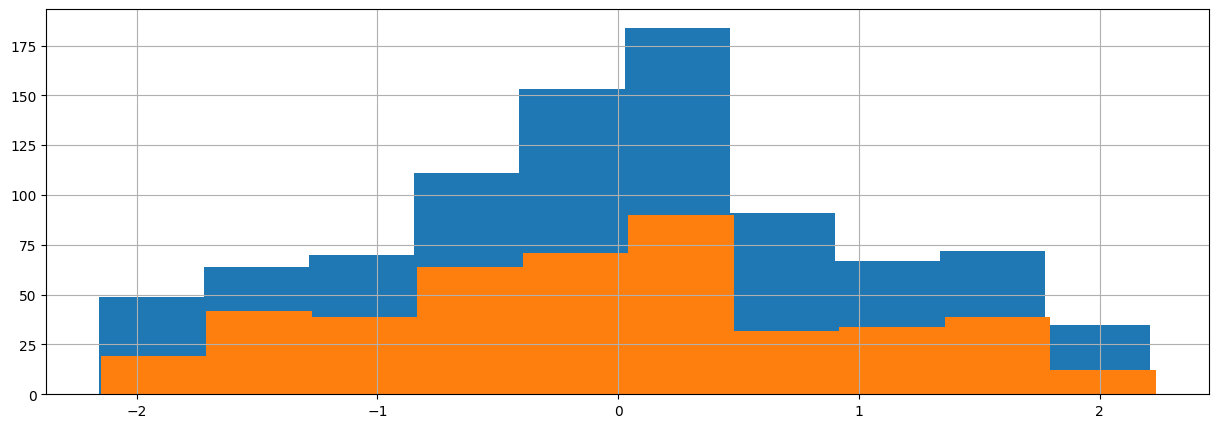

In [126]:
pd.Series(y_train_t).hist(figsize=(15, 5))
pd.Series(y_test_t).hist(figsize=(15, 5))
plt.show()

This code snippet serves the purpose of transforming the target variable using the Yeo-Johnson method through the PowerTransformer class. By applying this transformation to both the training `y_train` and `test` data, the code aims to alleviate the impact of non-normality in the data distribution. 

The subsequent creation and visualization of histograms provide an overview of the resulting transformed data distribution, offering insights into the effectiveness of the transformation in achieving a more normal distribution. This process can be particularly beneficial for improving the performance of certain machine learning algorithms that assume or benefit from normally distributed data.

In [78]:
from sklearn.compose import ColumnTransformer

cat_cols = ['smoker']
num_cols = [col for col in X_train.columns if col not in cat_cols]

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), cat_cols)
    ],
    remainder='passthrough'
)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

pipeline.fit(X_train, y_train_t, regressor__sample_weight=y_train / y_train.min())

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat', OneHotEncoder(),
                                                  ['smoker'])])),
                ('regressor', LinearRegression())])

This code creates a pipeline that combines data preprocessing and modeling for linear regression. The pipeline performs necessary processing on categorical columns (via One-Hot encoding) while leaving numerical columns unchanged. Next, a linear regression is applied to predict the target variable. Sample weights are used to give more importance to certain observations during model training. The overall goal is to build an enhanced linear regression model by handling different data types and accounting for sample weights.

Now that we've trained our model, we can use it to generate predictions on both our training and test sets:

In [79]:
y_pred_train = pipeline.predict(X_train)
y_pred_test = pipeline.predict(X_test)

Remember that the model was trained based on a transformed version of the target. Therefore we need to perform the inverse **Yeo-Johnson** transform to convert the model predictions to the original format of the target:

In [80]:
y_pred_train = pt.inverse_transform(y_pred_train.reshape(-1, 1))[:, 0]
y_pred_test = pt.inverse_transform(y_pred_test.reshape(-1, 1))[:, 0]

In [83]:
base_perf_train = calc_model_performance(y_train, y_pred_train)

In [85]:
base_perf_train

{'Root Mean Squared Error': 5964.030079525333,
 'Mean Squared Error': 35569654.78948296,
 'Mean Absolute Error': 4583.192074027705,
 'Mean Absolute Percentage Error': 0.7487184929524536,
 'R Squared': 0.757213156507561}

In [81]:
base_perf_test = calc_model_performance(y_test, y_pred_test)

In [82]:
base_perf_test

{'Root Mean Squared Error': 5752.477398059861,
 'Mean Squared Error': 33090996.215189554,
 'Mean Absolute Error': 4534.422635060551,
 'Mean Absolute Percentage Error': 0.7565371511851267,
 'R Squared': 0.7741917232715521}

### **Check normality of residuals**

We can check the normality of residuals using a QQ (quantile-quantile) plot. This plots the value of each actual quantile (from the data) vs the theoretical quantile (assuming a normal distribution). If the data is perfectly normally distributed, you'd expect the datapoints to lie on the line.

We'll also use a histogram as a more interpretable visualisation of the residuals.

In [86]:
residuals_train = y_train - y_pred_train
residuals_test = y_test - y_pred_test

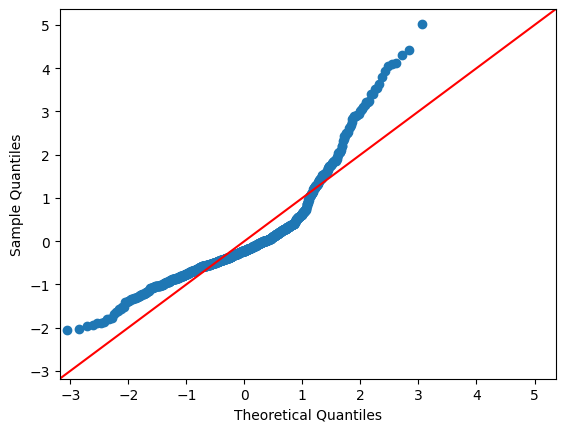

In [87]:
fig = sm.qqplot(
    residuals_train, 
    fit=True, 
    line='45'
)

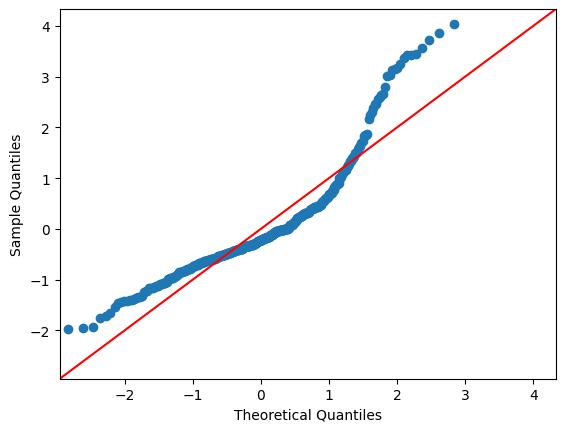

In [88]:
fig = sm.qqplot(
    residuals_test, 
    fit=True, 
    line='45'
)

In [89]:
plot_residuals(y_true=y_train, y_pred=y_pred_train)

Our residuals are not perfectly normally distributed, but are pretty close!

### **Check homoscedasticity**

We can check for homoscedasticity using a scatterplot, where the target is shown along the x-axis and the residuals are shown along the y-axis. We would expect the datapoints to be equally distributed across the y-axis as x (i.e. the target value) increases:

In [90]:
px.scatter(x=y_train, y=residuals_train)

In [91]:
px.scatter(x=y_test, y=residuals_test)

Our model exhibits significant heteroscedasticity (i.e. the variance of the residuals is not homogeneous with respect to the target). Since this is our baseline model

# XGBRegressor

In [103]:
rfe = RFE(estimator=XGBRegressor())
xgb = XGBRegressor()

In [109]:
prep = ColumnTransformer([
    ('ohe', OneHotEncoder(), cat_cols)
    ],
    remainder="passthrough"
)

In [110]:
pipe = Pipeline([
    ("preprocessor", prep),
    ("rfe", rfe),
    ("xgb", xgb)
])

Now we create our pipeline by specifying the list of sequential processes we want to run. The output of each step is passed to the next, with the final step being an estimator 

In [111]:
num_features = X_train.shape[1]
search_spaces = {
    'rfe__n_features_to_select': Integer(1, num_features), # Num features returned by RFE
    'xgb__n_estimators': Integer(1, 500), # Num trees built by XGBoost
    'xgb__max_depth': Integer(2, 8), # Max depth of trees built by XGBoost
    'xgb__reg_lambda': Integer(1, 200), # Regularisation term (lambda) used in XGBoost
    'xgb__learning_rate': Real(0, 1), # Learning rate used in XGBoost
    'xgb__gamma': Real(0, 2000) # Gamma used in XGBoost
}

Now we can initiate the parameter optimisation process using our training set:

In [112]:
xgb_bs_cv = BayesSearchCV(
    estimator=pipe, # Pipeline
    search_spaces=search_spaces, # Search spaces
    scoring='neg_root_mean_squared_error', # BayesSearchCV tries to maximise scoring metric, so negative RMSE used
    n_iter=75, # Num of optimisation iterations
    cv=3, # Number of folds
    verbose=3, # Show progress
    random_state=0 # Ensures reproducible results
)

In [113]:
xgb_bs_cv.fit(
    X_train, 
    y_train,
)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END rfe__n_features_to_select=2, xgb__gamma=1352.1590177538271, xgb__learning_rate=0.622709752629437, xgb__max_depth=6, xgb__n_estimators=430, xgb__reg_lambda=196;, score=-6576.270 total time=   2.7s
[CV 2/3] END rfe__n_features_to_select=2, xgb__gamma=1352.1590177538271, xgb__learning_rate=0.622709752629437, xgb__max_depth=6, xgb__n_estimators=430, xgb__reg_lambda=196;, score=-6982.957 total time=   1.4s
[CV 3/3] END rfe__n_features_to_select=2, xgb__gamma=1352.1590177538271, xgb__learning_rate=0.622709752629437, xgb__max_depth=6, xgb__n_estimators=430, xgb__reg_lambda=196;, score=-6768.849 total time=   1.7s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END rfe__n_features_to_select=2, xgb__gamma=1957.8073168527233, xgb__learning_rate=0.9084383736699745, xgb__max_depth=6, xgb__n_estimators=132, xgb__reg_lambda=33;, score=-7091.444 total time=   1.0s
[CV 2/3] END rfe__n_features_to_select=2, xgb_

BayesSearchCV(cv=3,
              estimator=Pipeline(steps=[('preprocessor',
                                         ColumnTransformer(remainder='passthrough',
                                                           transformers=[('ohe',
                                                                          OneHotEncoder(),
                                                                          ['smoker'])])),
                                        ('rfe',
                                         RFE(estimator=XGBRegressor(base_score=None,
                                                                    booster=None,
                                                                    callbacks=None,
                                                                    colsample_bylevel=None,
                                                                    colsample_bynode=None,
                                                                    colsample_bytree=None,
                                                                    early_stopping_rounds=None,
                                                                    enable_categorical=Fals...
                             'xgb__gamma': Real(low=0, high=2000, prior='uniform', transform='normalize'),
                             'xgb__learning_rate': Real(low=0, high=1, prior='uniform', transform='normalize'),
                             'xgb__max_depth': Integer(low=2, high=8, prior='uniform', transform='normalize'),
                             'xgb__n_estimators': Integer(low=1, high=500, prior='uniform', transform='normalize'),
                             'xgb__reg_lambda': Integer(low=1, high=200, prior='uniform', transform='normalize')},
              verbose=3)

Let's first look at how each parameter set performed across each fold. Each record in the dataset corresponds to a parameter set that was tested. We rank by `rank_test_score` to ensure the best performing parameter set is shown at the top:

In [114]:
cv_results = pd.DataFrame(xgb_bs_cv.cv_results_).sort_values('rank_test_score')

In [115]:
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_rfe__n_features_to_select,param_xgb__gamma,param_xgb__learning_rate,param_xgb__max_depth,param_xgb__n_estimators,param_xgb__reg_lambda,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
13,0.492979,0.114396,0.012567,0.003726,3,1501.654053,0.413354,3,80,180,"{'rfe__n_features_to_select': 3, 'xgb__gamma':...",-4157.400461,-4965.765998,-4902.952577,-4675.373012,367.158507,1
15,0.501304,0.181447,0.007560,0.001548,3,1195.958112,0.422921,3,82,179,"{'rfe__n_features_to_select': 3, 'xgb__gamma':...",-4149.589191,-4962.581890,-4921.567740,-4677.912940,373.956350,2
71,0.312757,0.037059,0.006004,0.003571,3,2000.0,0.435455,2,83,200,"{'rfe__n_features_to_select': 3, 'xgb__gamma':...",-4193.800802,-4964.925935,-4887.719355,-4682.148697,346.749635,3
73,0.497856,0.058181,0.006068,0.001244,3,1360.743351,0.122721,2,339,189,"{'rfe__n_features_to_select': 3, 'xgb__gamma':...",-4197.804409,-4963.190934,-4886.382293,-4682.459212,344.134277,4
74,0.455696,0.069277,0.010096,0.002348,3,905.146091,0.125818,2,336,200,"{'rfe__n_features_to_select': 3, 'xgb__gamma':...",-4202.985731,-4973.328374,-4885.647110,-4687.320405,344.341941,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14,0.427442,0.235628,0.010019,0.003919,3,1457.272106,0.358557,3,1,200,"{'rfe__n_features_to_select': 3, 'xgb__gamma':...",-16589.117726,-14598.674803,-15441.840268,-15543.210932,815.750275,71
57,1.557921,0.799276,0.015366,0.012994,3,846.116412,0.0,7,500,84,"{'rfe__n_features_to_select': 3, 'xgb__gamma':...",-19016.356974,-17163.287836,-17897.134903,-18025.593238,761.945958,72
46,0.591750,0.227291,0.010546,0.004362,3,2000.0,0.0,2,135,163,"{'rfe__n_features_to_select': 3, 'xgb__gamma':...",-19016.356974,-17163.287836,-17897.134903,-18025.593238,761.945958,72
29,0.434777,0.074577,0.010565,0.002908,3,2000.0,0.0,2,196,200,"{'rfe__n_features_to_select': 3, 'xgb__gamma':...",-19016.356974,-17163.287836,-17897.134903,-18025.593238,761.945958,72


Now, let's generate predictions on both our training and test sets using the model trained with our best performing parameters:

In [116]:
y_pred_train_xgb = xgb_bs_cv.predict(X_train)
y_pred_test_xgb = xgb_bs_cv.predict(X_test)

In [117]:
xgb_perf_train = calc_model_performance(y_train, y_pred_train_xgb)

In [118]:
xgb_perf_train

{'Root Mean Squared Error': 4144.72597331536,
 'Mean Squared Error': 17178753.39387496,
 'Mean Absolute Error': 2345.4207978660365,
 'Mean Absolute Percentage Error': 0.29464729849599547,
 'R Squared': 0.8827434413879351}

In [119]:
xgb_perf_test = calc_model_performance(y_test, y_pred_test_xgb)

In [120]:
xgb_perf_test

{'Root Mean Squared Error': 4702.351935478104,
 'Mean Squared Error': 22112113.725094665,
 'Mean Absolute Error': 2666.388096436068,
 'Mean Absolute Percentage Error': 0.3412412384406359,
 'R Squared': 0.8491100641812912}

In [121]:
perf_comp_train = compare_model_performance(base_perf_train, xgb_perf_train)
perf_comp_test = compare_model_performance(base_perf_test, xgb_perf_test)

## **Comparison to the baseline model**

In [122]:
perf_comp_train

,base,new,abs_improvement,perc_improvement
Root Mean Squared Error,5964.03,4144.73,-1819.30,-30.50
Mean Squared Error,35569654.79,17178753.39,-18390901.40,-51.70
Mean Absolute Error,4583.19,2345.42,-2237.77,-48.83
Mean Absolute Percentage Error,0.75,0.29,-0.46,-61.33
R Squared,0.76,0.88,0.12,15.79


In [123]:
perf_comp_test

,base,new,abs_improvement,perc_improvement
Root Mean Squared Error,5752.48,4702.35,-1050.13,-18.26
Mean Squared Error,33090996.22,22112113.73,-10978882.49,-33.18
Mean Absolute Error,4534.42,2666.39,-1868.03,-41.20
Mean Absolute Percentage Error,0.76,0.34,-0.42,-55.26
R Squared,0.77,0.85,0.08,10.39


**We can observe a significant decrease the errors and an increase in the $R^2$ value for the XGBoost model.**

**Most importantly, the RMSE (our model evaluation metric that we defined at the beginning of the exercise) has decreased by ~22% on the test set!**